In [1]:
import os
import sys

# Add the project's root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import random

import numpy as np
import torch

from GP_comp.GP import generate_grids
from SGLD_v7 import SgldBayesianRegression as V7, select_significant_voxels
from models.stgp_neural_network import STGPNeuralNetwork
from simulate_single_modality import simulate_data
from utils import generate_linear_data, plot_values, plot_mse, plot_sigma_squared
# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


In [2]:
in_feature = 5

In [3]:
# Step 2: Generate synthetic data
# simulate a batch of images
dim = in_feature           # e.g. 16 for a 16×16 grid → V=256
r2 = 0.8                  # signal-to-noise ratio
n = 1000                  # number of images/samples
v_list, true_beta, img, Y, true_sigma2 = simulate_data(
    n=n, r2=r2, dim=dim, random_seed=42)
# torch tensors
X = torch.from_numpy(img).float().to('cpu')    # shape [n, V]
y = torch.from_numpy(Y).float().to('cpu')      # shape [n]
grids = v_list                                  # shape [V, 2]
# pick one of your simulated images
idx = 0
inputs = X[idx : idx+1]       # shape [1, V]
expected_y = Y[idx]
print(f"Simulated {n} images of {dim}×{dim} = {img.shape[1]} pixels")

Simulated 1000 images of 5×5 = 25 pixels


In [4]:
# Step 4: Build model
model = STGPNeuralNetwork(
    in_feature=in_feature,
    grids=grids,
    fully_connected_layers =[10, 50, 1],
    dimensions=2
)

In [5]:
# Step 5: Train with SGLD
trainer = V7(
    step_size=0.005,
    num_epochs=300,  # fix this back to 300 later
    burn_in_epochs=100,
    batch_size=100,
    model=model
)

Epoch 1/300
Epoch 101/300
Epoch 201/300
Threshold δ=0.896, selecting r=3 voxels at FDR=0.05


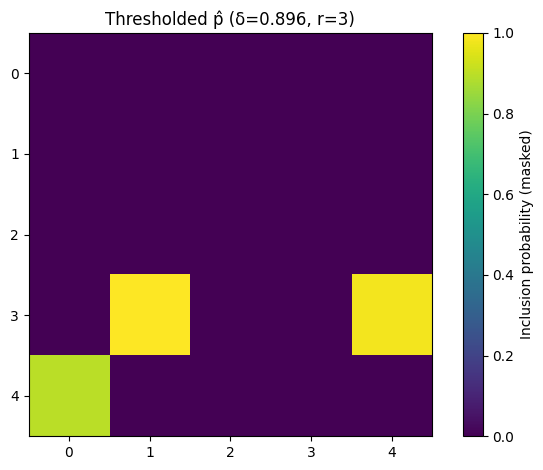

predict (sample_avg)::variance_prediction=[[741.1645]]
Y(predicted)=tensor([[65.3527]]) Y(expected)=13.999441707220495


In [6]:
indices = torch.randperm(X.size(0))
X, y = X[indices], y[indices]
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Train with MSE tracking every 10 epochs
trainer.train(X_train, y_train, X_test, y_test, mse_eval_interval=10, true_sigma2=true_sigma2)

print(f"Y(predicted)={trainer.predict(inputs, gamma=0.05)} Y(expected)={expected_y}")

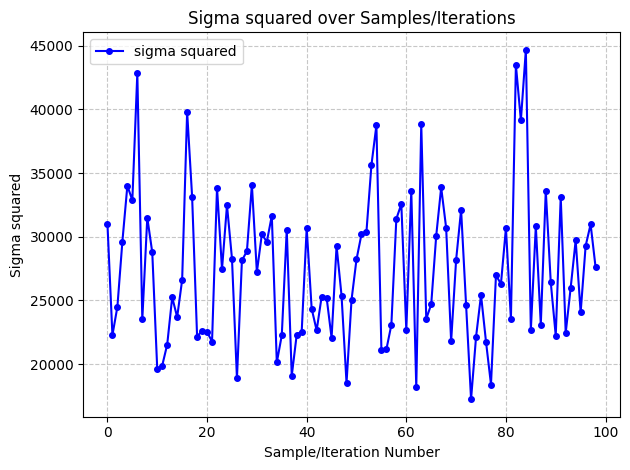

In [13]:
plot_sigma_squared(trainer, -100,-1)

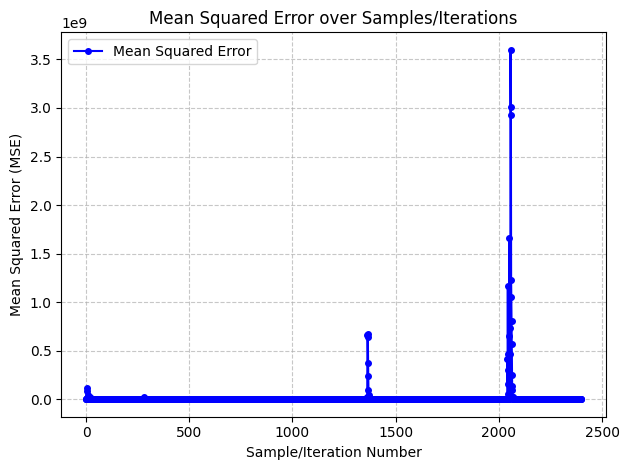

In [12]:
plot_mse(trainer)

In [ ]:
print(trainer.samples['mse'][-10:])